In [160]:
import gc
import json
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import sample
from matplotlib.pyplot import figure
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralBiclustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Importing Full Corpus and Sampling

First I'll start by importing the full corpus from the utterance JSON Lines file saved from the last assignment.

Due to the size of the corpus and being 100 categories and ~240,000 documents, I chose to use 7 categories and 3000 documents as the 'full corpus' and 7 categories and 300 documents as the reduced corpus.

In [2]:
# Load JSON lines file for the full corpus
corpus = []
with open('utterances.jl', encoding='utf8') as f:
    for line in f:
        corpus.append(json.loads(line))

In [173]:
corpusDF['subreddit'].unique()

array(['singapore', 'tifu', 'cringepics', 'motorcycles',
       'TwoXChromosomes', 'hockey', 'sex', 'Christianity', 'conspiracy',
       'canada', 'pokemontrades', 'Guildwars2', 'askscience', 'IAmA',
       'australia', 'relationships', 'Bitcoin', 'business',
       'electronic_cigarette', 'MMA', 'DebateReligion', 'skyrim',
       'movies', 'WTF', 'Android', 'OkCupid', 'Frugal', 'anime',
       'todayilearned', 'Fitness', 'SquaredCircle', 'photography',
       'hiphopheads', 'POLITIC', 'apple', 'science', 'AskMen', 'pokemon',
       'offbeat', 'Games', 'Minecraft', 'guns', 'AskWomen', 'politics',
       'technology', 'wow', 'Music', 'tf2', 'cringe', 'techsupport',
       'news', 'cars', 'MensRights', 'malefashionadvice', 'buildapc',
       'worldnews', 'gifs', 'soccer', 'asoiaf', 'explainlikeimfive',
       'dayz', 'books', 'relationship_advice', 'aww', 'gonewild',
       'fantasyfootball', 'unitedkingdom', 'AmItheAsshole',
       'MovieDetails', 'nfl', 'AdviceAnimals', 'programming', 

In [174]:
corpusDF = pd.DataFrame(corpus) # Assign corpus to dataframe for ease of review 

reddits = ['Economics','nfl','programming','Games','AdviceAnimals','Fitness','funny','MovieDetails'] # Subreddits I want to include in my analysis 

fullDF= corpusDF[corpusDF['subreddit'].isin(reddits)].sample(n=3000, replace=False, random_state=11) # Treating as the full term matrix

reducedDF = fullDF.sample(n=300, replace=False, random_state=10).reset_index(drop=True) #Treating as the reduced matrix

Now that I have my matrices I'm going to create lists with teh tags (used for Doc2Vec), document IDs, and subreddits for later use.

In [175]:
tags = list() # Tagged documents used for Doc2Vec
ids = list() # Document IDs for later reference
subs = list() # Subreddit names
counter = 0 # Used as the tag ID for each document, just for ease
for row in fullDF['body']:
    tags.append(TaggedDocument(row,[counter]))
    counter += 1
for row in fullDF['id']:
    ids.append(row)
for row in fullDF['subreddit']:
    subs.append(row)

# Creating Full Matrices

Generating the word embedding vectors using the Doc2Vec network. I decided to stick with a vector size of 4, which was the vector size used in the last programming assignment. 

## Doc2Vec

In [176]:
gc.collect()
model = Doc2Vec(tags, vector_size = 4, window=2, min_count=1, workers = 8)

In [177]:
# Creating a dataframe from the generated vectors 
# Appending the document IDs and subreddits 
docDF = pd.DataFrame(model.dv.vectors)
docDF.insert(0, 'id', ids)
docDF['subreddit'] = subs
docDF.head()

,id,0,1,2,3,subreddit
0,e6gq3eu,-0.447038,-0.307755,0.107166,0.405114,programming
1,e5kwa21,0.055824,-0.009648,-0.205609,-0.109854,MovieDetails
2,e5aqyoc,-0.310580,0.017617,0.145696,0.156101,AdviceAnimals
3,e5qo3iw,-0.667591,-0.358015,0.542909,0.065514,Economics
4,e5yubax,0.026676,0.218132,-0.207087,-0.069602,MovieDetails


## TF-IDF

Recreating the TF-IDF matrix using the 'full' document matrix of 3000 documents.

In [178]:
# separating out the body text, appending to a list and and joining back into strings for another list
individualDocs = list()
newDocs = list()
for row in fullDF['body']:
    individualDocs.append(row)
for doc in individualDocs:
    strings = ' '.join(doc)
    newDocs.append(strings)

In [179]:
from sklearn.feature_extraction.text import TfidfVectorizer

gc.collect()
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')
tfidf_wm = tfidfvectorizer.fit_transform(newDocs)
tfidf_tokens = tfidfvectorizer.get_feature_names()
tfidfDF = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)
tfidfDF.head()

,aaddbc,aapl,aaron,aawww,abandon,abandoned,abandoning,abdomen,abducted,abductees,...,zimbabwe,zojirushi,zombie,zombies,zone,zones,zoom,zuckerberg,zzzzzzzzz,台湾第一名
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Creating Reduced Matrices

Now that I have the full matrices created by both TF-IDF and Doc2Vec, I'll do the same and create the reduced matrices keeping the same vector size.

## Doc2Vec

In [180]:
reducedtags = list()
reducedids = list()
reducedsubs = list()
counter = 0
for row in reducedDF['body']:
    reducedtags.append(TaggedDocument(row,[counter]))
    counter += 1
for row in reducedDF['id']:
    reducedids.append(row)
for row in reducedDF['subreddit']:
    reducedsubs.append(row)

In [181]:
gc.collect()
model2 = Doc2Vec(reducedtags, vector_size = 4, window=2, min_count=1, workers = 8)
reduceddocDF = pd.DataFrame(model2.dv.vectors)
reduceddocDF.insert(0, 'id', reducedids)
reduceddocDF['subreddit'] = reducedsubs
reduceddocDF.head()

,id,0,1,2,3,subreddit
0,e5z63ab,-0.137063,-0.138672,-0.232889,0.226549,programming
1,e6w94pi,0.088808,0.007230,-0.246030,-0.128189,funny
2,e5klp92,-0.249928,0.054691,0.083862,0.122163,MovieDetails
3,e5ykuem,-0.117507,-0.072595,-0.065058,-0.213912,Games
4,e5dm356,0.037369,0.256080,-0.213321,-0.072981,Economics


## TF-IDF

In [182]:
reducedindividualDocs = list()
reducednewDocs = list()
for row in reducedDF['body']:
    reducedindividualDocs.append(row)
for doc in individualDocs:
    strings = ' '.join(doc)
    reducednewDocs.append(strings)

In [183]:
gc.collect()
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')
tfidf_wm = tfidfvectorizer.fit_transform(reducednewDocs)
tfidf_tokens = tfidfvectorizer.get_feature_names()
reducedtfidfDF = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)
reducedtfidfDF.head()

,aaddbc,aapl,aaron,aawww,abandon,abandoned,abandoning,abdomen,abducted,abductees,...,zimbabwe,zojirushi,zombie,zombies,zone,zones,zoom,zuckerberg,zzzzzzzzz,台湾第一名
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Determining Optimal K-means Cluster Count 

My next step is to determine the optimal cluster count. I'll be using both the silhouette score of each cluster, as well as the elbow method.

Based on the results, the most optimal cluster count is 8.

In [184]:
# Removing ID and subreddit information
reducedDFvec = reduceddocDF.iloc[:,1:-1]

In [185]:
inertia = [] # will hold inertia values
silscore = dict() # will hold silhouette scores and cluster count

# Loop to test different cluster counts
for k in range(2,16):
    km = KMeans(n_clusters=k, random_state = 50)
    pred = km.fit_predict(reducedDFvec)
    sil = silhouette_score(reducedDFvec,pred)
    silscore[k] = sil
    inertia.append([k,km.inertia_])
clusnum = max(score.items(), key=operator.itemgetter(1))[0] # gets the cluster number with the maximum value in the dictionary
silval = max(score.values()) #retrieves the max score
print("Based on the silhouette score of {}, the optimal number of clusters is {} having an inertia of {}".format(silval,clusnum,inertia[(clusnum-2)][1]))

Based on the silhouette score of 0.24598057568073273, the optimal number of clusters is 8 having an inertia of 9.749333381652832


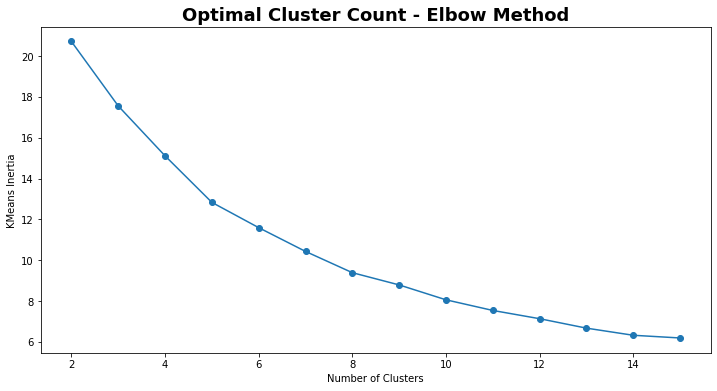

In [186]:
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Cluster Count - Elbow Method',  fontsize=18, fontweight='demi')
plt.ylabel('KMeans Inertia')
plt.xlabel('Number of Clusters')
plt.show()

# K-means Clustering

Performing K-means clustering using 8 clusters. I am also performing t-SNE on the reduced Doc2Vec dataframe, to reduce the dimensions from 4 to 2 for plotting.

## Clustering using original data

In [251]:
# K-means clustering
kmeans = KMeans(
    init = 'random',
    n_clusters = 8, # determined by earlier tests
    n_init = 10,
    max_iter = 300,
    random_state = 42
)

labels = kmeans.fit_predict(reducedDFvec) # determining clusters

tsne = TSNE(n_components=2,random_state=0) # using t-SNE for dimensionality reduction
tsnePoints = tsne.fit_transform(reducedDFvec) # storing t-SNE values for plotting

In [252]:
# creating ground truth labels to color points
gtlabels = reduceddocDF.copy()
unique_vals = gtlabels['subreddit'].unique()
gtlabels['subreddit'].replace(to_replace=unique_vals,
           value= list(range(len(unique_vals))),
           inplace=True)

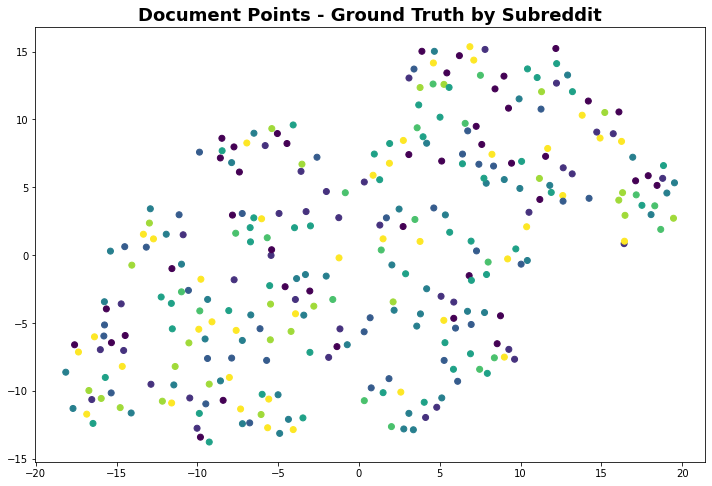

In [253]:
# ground truth plot
plt.rcParams["figure.figsize"] = [12,8]
plt.scatter(tsnePoints[:,0],tsnePoints[:,1],c=gtlabels['subreddit'])
plt.title('Document Points - Ground Truth by Subreddit', fontsize=18, fontweight='demi')
plt.show()

When plotting the clusters we can see some distinguishable clusters, but with nearly every cluster having overlap. 

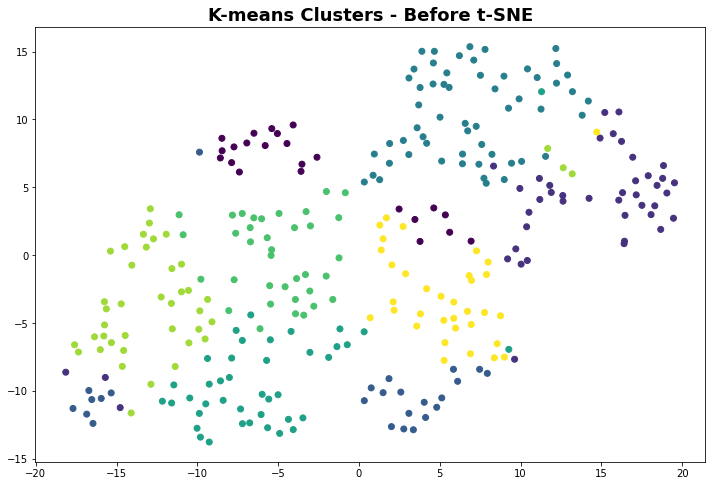

In [254]:
plt.rcParams["figure.figsize"] = [12,8]
plt.scatter(tsnePoints[:,0],tsnePoints[:,1],c=labels)
plt.title('K-means Clusters - Before t-SNE', fontsize=18, fontweight='demi')
plt.show()

## Clustering using t-SNE data

Clustering after t-SNE has shown to further distinguish clusters, with very little overlap compared to pre t-SNE. Performing t-SNE on the entire dataset beforehand also allows for clusters to be easily plotted.

In [255]:
# K-means clustering
kmeans = KMeans(
    init = 'random',
    n_clusters = 8, # determined by earlier tests
    n_init = 10,
    max_iter = 300,
    random_state = 42
)

labels = kmeans.fit_predict(tsnePoints) # determining clusters
centroids = kmeans.cluster_centers_

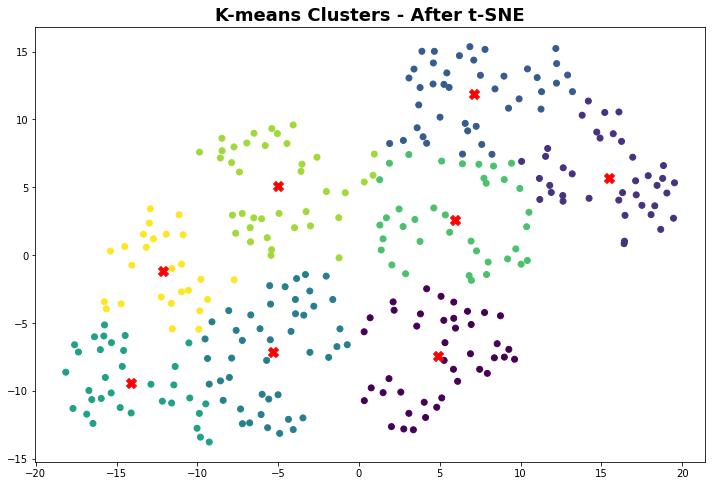

In [256]:
plt.rcParams["figure.figsize"] = [12,8]
plt.scatter(tsnePoints[:,0],tsnePoints[:,1],c=labels)
plt.scatter(centroids[:,0],centroids[:,1],marker='X',s=100,c='red')
plt.title('K-means Clusters - After t-SNE', fontsize=18, fontweight='demi')
plt.show()

Creating a plot of subreddits by cluster.

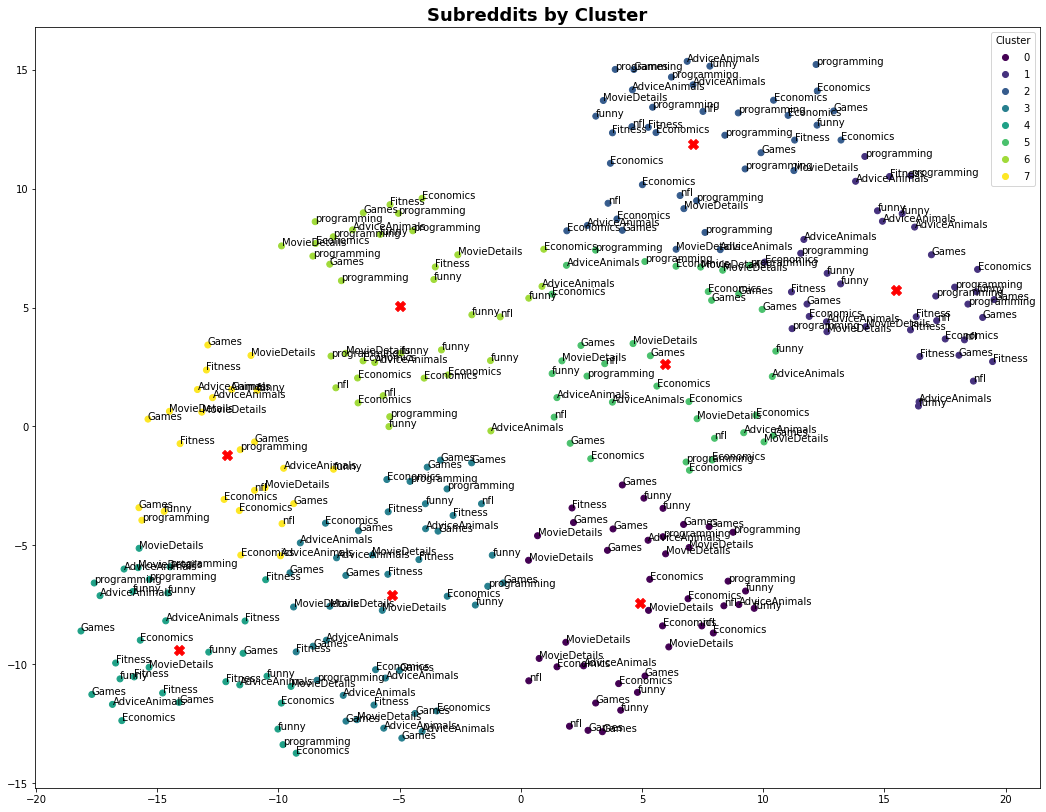

In [192]:
plt.rcParams["figure.figsize"] = [18,14]
fig, ax = plt.subplots()
sc = ax.scatter(tsnePoints[:,0], tsnePoints[:,1], c=labels)
ax.scatter(centroids[:,0],centroids[:,1],marker='X',s=100,c='red')
ax.set_title('Subreddits by Cluster', fontsize=18, fontweight='demi')
ax.legend(*sc.legend_elements(), title = 'Cluster', loc='upper right')
for i, txt in enumerate(reducedDF['subreddit']):
    ax.annotate(txt, (tsnePoints[:,0][i], tsnePoints[:,1][i]))

plt.show()

In [193]:
kmeanDF = reduceddocDF.copy()
kmeanDF['labels'] = labels
kmeanDF.head(15)

,id,0,1,2,3,subreddit,labels
0,e5z63ab,-0.137063,-0.138672,-0.232889,0.226549,programming,3
1,e6w94pi,0.088808,0.007230,-0.246030,-0.128189,funny,1
2,e5klp92,-0.249928,0.054691,0.083862,0.122163,MovieDetails,0
3,e5ykuem,-0.117507,-0.072595,-0.065058,-0.213912,Games,7
4,e5dm356,0.037369,0.256080,-0.213321,-0.072981,Economics,1
5,e5kgya2,-0.095680,0.066429,-0.141859,0.065749,Games,2
6,e5f8mbc,0.143315,-0.200444,-0.208442,-0.249188,Games,7
7,e6malfe,0.123022,-0.222241,0.149727,0.173222,nfl,0
8,e6f22hj,-0.179482,-0.102754,-0.018450,0.045289,Games,3
9,e6lozm6,-0.050322,-0.211002,-0.076854,0.052587,Fitness,4


# Hierarchical Clustering

Hierarchical clustering exhibited very similar outcomes to that of K-means. 

## Clustering using original data

In [196]:
cluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean')  
cluster.fit_predict(reducedDFvec)

array([0, 2, 4, 0, 2, 3, 5, 1, 0, 0, 4, 1, 1, 0, 3, 6, 1, 0, 0, 4, 2, 5,
       2, 0, 1, 0, 0, 5, 4, 4, 2, 3, 1, 2, 3, 5, 6, 0, 1, 2, 6, 5, 4, 6,
       1, 2, 7, 2, 3, 1, 4, 5, 2, 4, 4, 4, 3, 3, 1, 4, 6, 0, 0, 0, 2, 6,
       6, 2, 7, 0, 3, 7, 3, 4, 4, 6, 0, 5, 6, 6, 6, 2, 1, 2, 0, 3, 0, 3,
       2, 3, 2, 2, 3, 4, 1, 0, 3, 0, 0, 7, 0, 0, 2, 2, 3, 4, 3, 6, 6, 4,
       3, 7, 5, 2, 1, 1, 6, 5, 0, 5, 3, 5, 7, 1, 7, 0, 2, 0, 1, 6, 1, 0,
       4, 6, 1, 5, 6, 6, 4, 7, 1, 1, 2, 4, 0, 6, 3, 3, 5, 0, 0, 3, 7, 2,
       5, 5, 1, 4, 7, 6, 1, 0, 2, 1, 1, 3, 6, 4, 6, 6, 4, 3, 0, 4, 1, 2,
       7, 4, 0, 3, 4, 1, 1, 6, 4, 5, 6, 7, 7, 4, 1, 1, 2, 0, 2, 6, 6, 1,
       4, 1, 4, 3, 4, 1, 1, 2, 2, 4, 7, 1, 3, 6, 3, 4, 4, 2, 5, 0, 4, 2,
       6, 5, 2, 7, 7, 2, 7, 0, 7, 5, 1, 1, 3, 2, 5, 2, 3, 2, 3, 3, 0, 6,
       7, 0, 5, 3, 7, 3, 6, 3, 4, 7, 2, 3, 3, 5, 0, 1, 0, 0, 1, 5, 5, 1,
       5, 2, 2, 3, 2, 3, 3, 3, 6, 5, 1, 4, 1, 0, 4, 1, 0, 4, 6, 4, 0, 6,
       3, 1, 0, 4, 7, 3, 5, 2, 5, 4, 4, 6, 3, 1], d

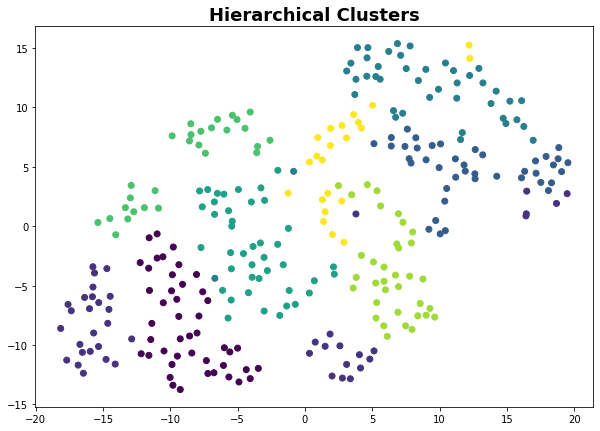

In [197]:
plt.figure(figsize=(10, 7))  
plt.scatter(tsnePoints[:,0], tsnePoints[:,1], c=cluster.labels_) 
plt.title('Hierarchical Clusters', fontsize=18, fontweight='demi')
plt.show()

## Clustering using t-SNE data

In [198]:
tsne = TSNE(n_components=2,random_state=0)
tsnePoints = tsne.fit_transform(reducedDFvec)

In [199]:
cluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean')  
cluster.fit_predict(tsnePoints)

array([6, 1, 5, 0, 1, 1, 0, 2, 5, 6, 3, 0, 0, 6, 1, 7, 2, 0, 6, 5, 1, 3,
       1, 6, 2, 6, 6, 3, 3, 5, 1, 4, 2, 4, 1, 3, 2, 6, 0, 1, 7, 0, 5, 7,
       0, 1, 4, 1, 1, 0, 3, 3, 1, 5, 5, 5, 1, 4, 0, 5, 7, 6, 0, 6, 7, 7,
       2, 1, 7, 0, 4, 4, 4, 5, 3, 2, 6, 0, 7, 2, 2, 4, 0, 4, 0, 1, 6, 1,
       4, 4, 4, 1, 4, 5, 0, 6, 1, 0, 6, 4, 0, 6, 4, 7, 1, 3, 4, 2, 2, 5,
       4, 3, 3, 1, 0, 0, 2, 3, 6, 0, 4, 0, 4, 0, 1, 6, 7, 6, 0, 2, 0, 0,
       3, 2, 0, 0, 7, 2, 3, 4, 0, 7, 1, 5, 6, 2, 4, 1, 0, 6, 0, 4, 7, 1,
       3, 3, 2, 5, 4, 7, 1, 0, 1, 2, 1, 1, 5, 3, 2, 2, 5, 1, 6, 3, 0, 1,
       7, 5, 6, 4, 3, 1, 2, 2, 3, 3, 2, 4, 4, 5, 2, 2, 1, 6, 1, 7, 2, 1,
       5, 2, 5, 4, 5, 0, 2, 1, 1, 5, 1, 0, 1, 7, 4, 5, 5, 1, 3, 0, 5, 4,
       5, 3, 1, 7, 4, 1, 4, 6, 4, 0, 2, 0, 5, 1, 0, 1, 1, 1, 4, 4, 0, 2,
       7, 6, 3, 4, 7, 3, 7, 4, 3, 7, 1, 1, 1, 0, 0, 6, 6, 6, 0, 3, 3, 2,
       0, 4, 1, 1, 4, 1, 4, 4, 2, 3, 0, 5, 1, 5, 3, 0, 0, 5, 2, 3, 0, 2,
       1, 0, 6, 3, 4, 1, 3, 7, 3, 5, 5, 2, 4, 0], d

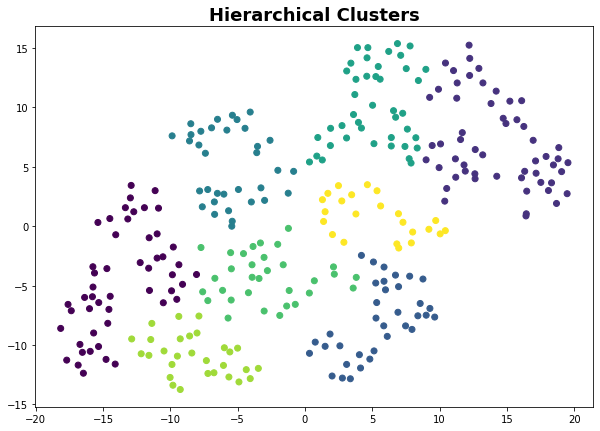

In [200]:
plt.figure(figsize=(10, 7))  
plt.scatter(tsnePoints[:,0], tsnePoints[:,1], c=cluster.labels_) 
plt.title('Hierarchical Clusters', fontsize=18, fontweight='demi')
plt.show()

In [201]:
hierDF = reduceddocDF.copy()
hierDF['labels'] = cluster.labels_
hierDF.head(15)

,id,0,1,2,3,subreddit,labels
0,e5z63ab,-0.137063,-0.138672,-0.232889,0.226549,programming,6
1,e6w94pi,0.088808,0.007230,-0.246030,-0.128189,funny,1
2,e5klp92,-0.249928,0.054691,0.083862,0.122163,MovieDetails,5
3,e5ykuem,-0.117507,-0.072595,-0.065058,-0.213912,Games,0
4,e5dm356,0.037369,0.256080,-0.213321,-0.072981,Economics,1
5,e5kgya2,-0.095680,0.066429,-0.141859,0.065749,Games,1
6,e5f8mbc,0.143315,-0.200444,-0.208442,-0.249188,Games,0
7,e6malfe,0.123022,-0.222241,0.149727,0.173222,nfl,2
8,e6f22hj,-0.179482,-0.102754,-0.018450,0.045289,Games,5
9,e6lozm6,-0.050322,-0.211002,-0.076854,0.052587,Fitness,6


# Topic Modeling

The subreddits used in this dataset were: 'Economics','nfl','programming','Games','AdviceAnimals','Fitness','funny','MovieDetails'.

LDA was ran on the reduced TF-IDF dataset with 5 components. I generated the top 30 words to provide a broader range to potentially identify the subreddits from the topic modeling.

In [220]:
lda = LatentDirichletAllocation(n_components=5,random_state=50)
lda.fit_transform(reducedtfidfDF)

array([[0.04116797, 0.04081154, 0.8359104 , 0.04096848, 0.04114161],
       [0.07607695, 0.07573161, 0.69607032, 0.07612109, 0.07600004],
       [0.72454611, 0.07091035, 0.06787395, 0.06856177, 0.06810783],
       ...,
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.07428674, 0.07424252, 0.7031883 , 0.07406987, 0.07421257],
       [0.10002189, 0.10002422, 0.10002285, 0.10002237, 0.59990867]])

In [221]:
for index, topic in enumerate(lda.components_):
    print(f'Top 30 words for Topic #{index}')
    print([tfidfvectorizer.get_feature_names()[i] for i in topic.argsort()[-30:]])
    print('\n')

Top 20 words for Topic #0
['saying', 'wages', 'jobs', 'need', 'different', 'year', 'shit', 'problem', 'talking', 'sure', 'want', 'thing', 'actually', 'make', 'better', 'really', 'good', 'going', 'know', 'thats', 'game', 'time', 'think', 'minimum', 'wage', 'years', 'games', 'work', 'people', 'like']


Top 20 words for Topic #1
['mean', 'cool', 'movie', 'source', 'know', 'going', 'luck', 'games', 'feel', 'really', 'saying', 'probably', 'actually', 'damn', 'want', 'right', 'wrong', 'things', 'whats', 'thats', 'make', 'point', 'pretty', 'time', 'game', 'like', 'people', 'think', 'fuck', 'good']


Top 20 words for Topic #2
['theyre', 'probably', 'great', 'better', 'going', 'sounds', 'right', 'understand', 'need', 'dumb', 'mean', 'sorry', 'best', 'make', 'actually', 'rice', 'money', 'good', 'makes', 'guys', 'movie', 'really', 'shit', 'people', 'think', 'true', 'thank', 'yeah', 'thats', 'like']


Top 20 words for Topic #3
['hard', 'internet', 'tell', 'yeah', 'maybe', 'time', 'really', 'years'

# Spectral Biclustering

Switching to spectral biclustering, it is even more distinguished between different clusters. However, my original Doc2Vec matrix only contained four vectors for each document, which limits the amount of clusters I can use to four. 

In [224]:
docDFvec = docDF.iloc[:,1:-1]

 # reducing dimensions using t-SNE 
tsne = TSNE(n_components=2,random_state=0)
tsnePoints = tsne.fit_transform(docDFvec)

In [225]:
# biclustering using four clusters, aligning to the number of vectors for each document
bicluster = SpectralBiclustering(n_clusters=4, random_state=0)
bicluster.fit(docDFvec)
bilabels = bicluster.row_labels_

Text(0.5, 1.0, 'Spectral Biclustering Clusters')

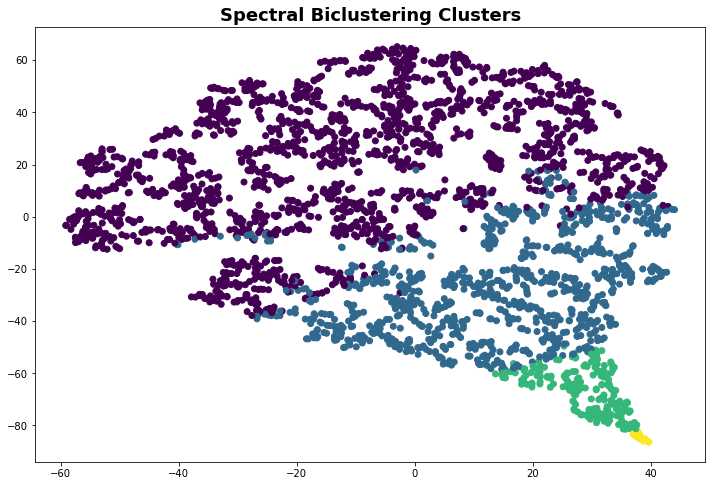

In [226]:
plt.figure(figsize=(12, 8))  
plt.scatter(tsnePoints[:,0], tsnePoints[:, 1], c=bilabels)
plt.title('Spectral Biclustering Clusters', fontsize=18, fontweight='demi')

In [249]:
spectralDF = docDF.copy()
spectralDF['labels'] = bilabels
print(spectralDF.head(20))
print(spectralDF.groupby('subreddit').count())

         id         0         1         2         3      subreddit  labels
0   e6gq3eu -0.447038 -0.307755  0.107166  0.405114    programming       1
1   e5kwa21  0.055824 -0.009648 -0.205609 -0.109854   MovieDetails       0
2   e5aqyoc -0.310580  0.017617  0.145696  0.156101  AdviceAnimals       0
3   e5qo3iw -0.667591 -0.358015  0.542909  0.065514      Economics       1
4   e5yubax  0.026676  0.218132 -0.207087 -0.069602   MovieDetails       0
5   e5ebb6s -0.124665  0.047594 -0.112499  0.081790  AdviceAnimals       0
6   e5ejdr2  0.090203 -0.223133 -0.150524 -0.224996          Games       0
7   e6djmti -0.297494 -0.430496  0.611928  0.408340  AdviceAnimals       1
8   e6owcxx -0.564611 -0.310692  0.391585  0.268344   MovieDetails       1
9   e5yrd5y -0.051771 -0.219246 -0.073374  0.053017   MovieDetails       0
10  e6echgg -0.844417 -0.556113  0.975025  0.239647          Games       2
11  e5yt0x1 -0.240026 -0.269598  0.354012  0.100144   MovieDetails       1
12  e5u9pnz  0.077434 -0.

In [247]:
spectralDF

,id,0,1,2,3,subreddit,labels
0,e6gq3eu,-0.447038,-0.307755,0.107166,0.405114,programming,1
1,e5kwa21,0.055824,-0.009648,-0.205609,-0.109854,MovieDetails,0
2,e5aqyoc,-0.310580,0.017617,0.145696,0.156101,AdviceAnimals,0
3,e5qo3iw,-0.667591,-0.358015,0.542909,0.065514,Economics,1
4,e5yubax,0.026676,0.218132,-0.207087,-0.069602,MovieDetails,0
...,...,...,...,...,...,...,...
2995,e5yx1wg,-1.053717,-0.663798,1.110928,0.694744,programming,2
2996,e5r31ko,-0.371729,-0.243782,0.302844,0.410593,nfl,1
2997,e5ok1k8,0.023361,-0.018102,-0.166645,-0.049860,MovieDetails,0
2998,e5p82su,-0.118141,-0.196229,0.255834,-0.194308,Economics,0
